# ICL Linear Classification Reproduction

In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt

## Data Generation

In [2]:
def data_gen(
    d: int,
    N: int,
    B: int,
    R: float,
    flip_prob: float = 0.0,
    device: str = "cpu",
    seed: int | None = None,
):

    if seed is not None:
        #keep base & flip RNG different. the original paper did not do this which led to issues when running their code.
        g_base = torch.Generator(device="cpu").manual_seed(seed)
        g_flip = torch.Generator(device="cpu").manual_seed(seed + 1)
    else:
        g_base = None
        g_flip = None

    mu = torch.randn(B, d, generator=g_base)#(B, d)
    mu = mu / mu.norm(dim=1, keepdim=True)  
    mu = R * mu                              

    labels = (torch.rand(B, N + 1, generator=g_base) > 0.5).float()#(B, N+1)
    y_signal = 2 * labels - 1                                  

    noise = torch.randn(B, N + 1, d, generator=g_base)#(B, N+1, d)

    x = (y_signal.unsqueeze(-1) * mu.unsqueeze(1) + noise)#(B, N+1, d)

    #introduce noise to labels
    if flip_prob > 0.0:
        flip_mask = torch.rand(B, N + 1, generator=g_flip) < flip_prob
        labels = torch.where(flip_mask, 1.0 - labels, labels)

    #output
    x_context = (x[:, :N, :]).to(device)           
    x_target = (x[:, -1, :]).to(device)           
    y_context = (labels[:, :N]).to(device)         
    y_target = (labels[:, -1]).to(device)        

    return (x_context, y_context, x_target, y_target)



### Data Testing

In [3]:
#simple testing
d, N, B, R = 1000, 20, 500, 5.0

x_ctx, y_ctx, x_tgt, y_tgt = data_gen(d, N, B, R, flip_prob=0.0, seed=100)

print("x_ctx shape:", x_ctx.shape)#(B, N, d)
print("y_ctx shape:", y_ctx.shape)#(B, N)
print("x_tgt shape:", x_tgt.shape)#(B, d)
print("y_tgt shape:", y_tgt.shape)#(B,)
#check printed shapes match comments

print("Context label mean:", y_ctx.mean().item())
print("Target label mean:", y_tgt.float().mean().item())
#around 0.5 assuming N is high enough

x_ctx shape: torch.Size([500, 20, 1000])
y_ctx shape: torch.Size([500, 20])
x_tgt shape: torch.Size([500, 1000])
y_tgt shape: torch.Size([500])
Context label mean: 0.49160000681877136
Target label mean: 0.5139999985694885


In [25]:
#noise tests
p = 0.3
seed = 100

#clean set (no flips)
x_ctx_clean, y_ctx_clean, x_tgt_clean, y_tgt_clean = data_gen(
    d, N, B, R, flip_prob=0.0, seed=seed
)

#p=0.3 flips
x_ctx_noisy, y_ctx_noisy, x_tgt_noisy, y_tgt_noisy = data_gen(
    d, N, B, R, flip_prob=p, seed=seed
)

#true for both
print("Context X equal:", torch.allclose(x_ctx_clean, x_ctx_noisy))
print("Target X equal:", torch.allclose(x_tgt_clean, x_tgt_noisy))

#about 0.3 for both
ctx_flip_rate = (y_ctx_clean != y_ctx_noisy).float().mean().item()
tgt_flip_rate = (y_tgt_clean != y_tgt_noisy).float().mean().item()

print(f"Context flip rate ~ {ctx_flip_rate:.3f} (target {p})")
print(f"Target  flip rate ~ {tgt_flip_rate:.3f} (target {p})")

Context X equal: True
Target X equal: True
Context flip rate ~ 0.297 (target 0.3)
Target  flip rate ~ 0.332 (target 0.3)


Now that all testing is done and if output looks correct as specificed by in-line comments, we can move on to model architecture.

## Model Definition

In [4]:
class LinearClassifier(nn.Module):
    def __init__(self, d: int):
        super().__init__()
        
        #Linear layer
        self.W = nn.Linear(d, d, bias=False)
        nn.init.zeros_(self.W.weight)

    #only forward pass
    def forward(self, x_ctx, y_ctx, x_tgt):
        B, N, d = x_ctx.shape

        y_signal = 2*y_ctx - 1 
        
        weighted = y_signal.unsqueeze(-1) * x_ctx   
        mu_hat = weighted.mean(dim=1)            

        v = self.W(mu_hat)     

        return (v * x_tgt).sum(dim=1)
    
    #use same model as target prediction to predict in context labels
    def compute_in_context_preds(self, x_ctx, y_ctx):

        B, N, d = x_ctx.shape
        y_signal = 2*y_ctx - 1

        mu_hat = (y_signal.unsqueeze(-1) * x_ctx).mean(dim=1)  
        v = self.W(mu_hat)             
        logits = (v.unsqueeze(1) * x_ctx).sum(dim=2)           
        
        return (logits > 0).float()



### Simple Model Tests

In [5]:
#test output shape after forward pass
def test_forward_shapes():
    d = 100
    N = 5
    B = 10

    x_ctx = torch.randn(B, N, d)
    y_ctx = (torch.rand(B, N) > 0.5).float()
    x_tgt = torch.randn(B, d)

    model = LinearClassifier(d)

    logits = model(x_ctx, y_ctx, x_tgt)

    print("logits shape:", logits.shape)
    assert logits.shape == (B,)

test_forward_shapes()

logits shape: torch.Size([10])


In [28]:
#forward pass is working and gradients exist 

def test_pass_and_grad():
    d = 50
    N = 3
    B = 4

    x_ctx = torch.randn(B, N, d, requires_grad=True)
    y_ctx = (torch.rand(B, N) > 0.5).float()
    x_tgt = torch.randn(B, d, requires_grad=True)

    model = LinearClassifier(d)

    logits = model(x_ctx, y_ctx, x_tgt).sum()
    logits.backward()

    assert model.W.weight.grad is not None
    print("Gradient shape:", model.W.weight.grad.shape)
    
test_pass_and_grad()

Gradient shape: torch.Size([50, 50])


Now that we have ran some simple sanity tests on our model architecture, we can move on to creating the training loop.

## Training Loop

In [6]:
#gets in context predictions + accuracy on a validation batch
def evaluate(model, d, N, B_val, R_val, flip_val=0.0, device="cpu"):
    model.eval()
    with torch.no_grad():

        #sample batch
        x_ctx, y_ctx, x_tgt, y_tgt = data_gen(d, N, B_val, R_val, flip_prob = flip_val, device=device)

        #forward pass
        logits = model(x_ctx, y_ctx, x_tgt)
        val_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_tgt.float())

        #compute target acc
        preds = (logits > 0).float()
        val_acc = (preds == y_tgt).float().mean().item()

        #compute icl acc
        ctx_preds = model.compute_in_context_preds(x_ctx, y_ctx)
        ctx_acc = (ctx_preds == y_ctx).float().mean().item()

        return val_loss.item(), val_acc, ctx_acc


In [7]:
def train_model(
    model,
    d: int,
    N: int,
    B: int,
    R_train: float,
    R_val: float,
    flip_train: float = 0.0,
    flip_val: float = 0.0,
    steps: int = 300,
    lr: float = 1e-2,
    device: str = "cpu",
    return_metrics=True
):
    model = model.to(device)
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    
    metrics = {
        "train_acc": [],
        "val_acc": [],
        "ic_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    for step in range(steps):
        x_ctx, y_ctx, x_tgt, y_tgt = data_gen(
            d, N, B, R_train, flip_prob=flip_train, device=device
        )

        logits = model(x_ctx, y_ctx, x_tgt)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            logits, y_tgt.float()
        )

        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        #get train acc
        train_acc = ((logits > 0).float() == y_tgt).float().mean().item()

        #get val acc
        val_loss, val_acc, ctx_acc = evaluate(
            model, d, N, B, R_val, flip_val=flip_val, device=device
        )
        
        metrics["train_loss"].append(loss.item())
        metrics["train_acc"].append(train_acc)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        metrics["ic_acc"].append(ctx_acc)

        #print updates every 10 steps
        if step % 10 == 0:
            print(
                f"Step {step:03d} | "
                f"Train Loss: {loss.item():.2f} | Train Acc: {train_acc:.2f} | "
                f"Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f} | "
                f"In-Context Acc: {ctx_acc:.2f}"
            )
    if return_metrics:
        return metrics
    return model


## Running the Training Loop

In [12]:
d = 50
N = 10
B = 50
R = d**0.5

model = LinearClassifier(d=d)
train_model(
    model,
    d,
    N,
    B,
    R,
    R,
    flip_train=0.2,
    flip_val=0.2,
    steps=1000,
    device="cuda",
)


Step 000 | Train Loss: 0.69 | Train Acc: 0.44 | Val Loss: 0.69 | Val Acc: 0.68 | In-Context Acc: 0.75
Step 010 | Train Loss: 0.58 | Train Acc: 0.84 | Val Loss: 0.58 | Val Acc: 0.78 | In-Context Acc: 0.81
Step 020 | Train Loss: 0.59 | Train Acc: 0.72 | Val Loss: 0.62 | Val Acc: 0.76 | In-Context Acc: 0.80
Step 030 | Train Loss: 0.55 | Train Acc: 0.74 | Val Loss: 0.63 | Val Acc: 0.64 | In-Context Acc: 0.79
Step 040 | Train Loss: 0.71 | Train Acc: 0.66 | Val Loss: 0.52 | Val Acc: 0.84 | In-Context Acc: 0.81
Step 050 | Train Loss: 0.55 | Train Acc: 0.78 | Val Loss: 0.45 | Val Acc: 0.86 | In-Context Acc: 0.83
Step 060 | Train Loss: 0.46 | Train Acc: 0.90 | Val Loss: 0.58 | Val Acc: 0.78 | In-Context Acc: 0.84
Step 070 | Train Loss: 0.57 | Train Acc: 0.78 | Val Loss: 0.58 | Val Acc: 0.72 | In-Context Acc: 0.82
Step 080 | Train Loss: 0.64 | Train Acc: 0.68 | Val Loss: 0.44 | Val Acc: 0.88 | In-Context Acc: 0.80
Step 090 | Train Loss: 0.60 | Train Acc: 0.74 | Val Loss: 0.45 | Val Acc: 0.86 | I

{'train_acc': [0.4399999976158142,
  0.6599999666213989,
  0.8799999952316284,
  0.85999995470047,
  0.7999999523162842,
  0.85999995470047,
  0.6800000071525574,
  0.7599999904632568,
  0.7799999713897705,
  0.7999999523162842,
  0.8399999737739563,
  0.7999999523162842,
  0.7599999904632568,
  0.7400000095367432,
  0.7199999690055847,
  0.8199999928474426,
  0.8199999928474426,
  0.8999999761581421,
  0.7400000095367432,
  0.8199999928474426,
  0.7199999690055847,
  0.7199999690055847,
  0.7999999523162842,
  0.7599999904632568,
  0.7799999713897705,
  0.8399999737739563,
  0.7999999523162842,
  0.8199999928474426,
  0.8399999737739563,
  0.7400000095367432,
  0.7400000095367432,
  0.9199999570846558,
  0.8199999928474426,
  0.699999988079071,
  0.7599999904632568,
  0.8399999737739563,
  0.85999995470047,
  0.7400000095367432,
  0.7999999523162842,
  0.7799999713897705,
  0.6599999666213989,
  0.7599999904632568,
  0.8399999737739563,
  0.8399999737739563,
  0.7400000095367432,
  0.

## Full Setup with Plots

In [13]:
#training loop will run with all values in index 0, then 1, etc.
d_vals = [100, 300, 500, 1000]
n_vals = [10, 20, 40, 80]
b_vals = [64, 64, 64, 64]              
r_vals = [d**0.3 for d in d_vals]
flips_train = [0.0, 0.1, 0.2, 0.3]
flips_val = flips_train

steps = 300
device = "cuda"

#will run a single experiment with predetermined vars
def run_experiment(
    d, N, B, R_train, R_val, flip_train, flip_val, steps=300, device="cpu"
):
    print(f"Running experiment with following hyperparams: d={d}, n={N}, b={B}, R={R_train}, flip={flip_train}")

    # build model
    model = LinearClassifier(d=d)

    # run training 
    metrics = train_model(
        model,
        d=d,
        N=N,
        B=B,
        R_train=R_train,
        R_val=R_val,
        flip_train=flip_train,
        flip_val=flip_val,
        steps=steps,
        device=device,
        return_metrics=True,   
    )

    #plot train, val, IC accuracy vs training step
    steps_axis = range(len(metrics["train_acc"]))

    plt.figure(figsize=(7,5))
    plt.plot(steps_axis, metrics["train_acc"], label="Train Acc")
    plt.plot(steps_axis, metrics["val_acc"], label="Val Acc")
    plt.plot(steps_axis, metrics["ic_acc"], label="In-Context Acc")
    plt.legend()
    plt.xlabel("Training Step")
    plt.ylabel("Accuracy")
    plt.title(f"Train, Validation, and In-Context Accuracies by Training Step for d={d}, N={N}, B={B}, noise={flip_train}")
    plt.show()

    return metrics


Running experiment with following hyperparams: d=100, n=10, b=64, R=3.9810717055349722, flip=0.0
Step 000 | Train Loss: 0.69 | Train Acc: 0.48 | Val Loss: 0.69 | Val Acc: 0.66 | In-Context Acc: 0.86
Step 010 | Train Loss: 0.64 | Train Acc: 0.95 | Val Loss: 0.62 | Val Acc: 0.95 | In-Context Acc: 1.00
Step 020 | Train Loss: 0.59 | Train Acc: 0.98 | Val Loss: 0.58 | Val Acc: 0.98 | In-Context Acc: 1.00
Step 030 | Train Loss: 0.54 | Train Acc: 0.97 | Val Loss: 0.54 | Val Acc: 1.00 | In-Context Acc: 1.00
Step 040 | Train Loss: 0.50 | Train Acc: 0.98 | Val Loss: 0.50 | Val Acc: 1.00 | In-Context Acc: 1.00
Step 050 | Train Loss: 0.46 | Train Acc: 1.00 | Val Loss: 0.45 | Val Acc: 1.00 | In-Context Acc: 1.00
Step 060 | Train Loss: 0.43 | Train Acc: 1.00 | Val Loss: 0.44 | Val Acc: 1.00 | In-Context Acc: 1.00
Step 070 | Train Loss: 0.42 | Train Acc: 0.98 | Val Loss: 0.40 | Val Acc: 1.00 | In-Context Acc: 1.00
Step 080 | Train Loss: 0.36 | Train Acc: 1.00 | Val Loss: 0.38 | Val Acc: 1.00 | In-Con

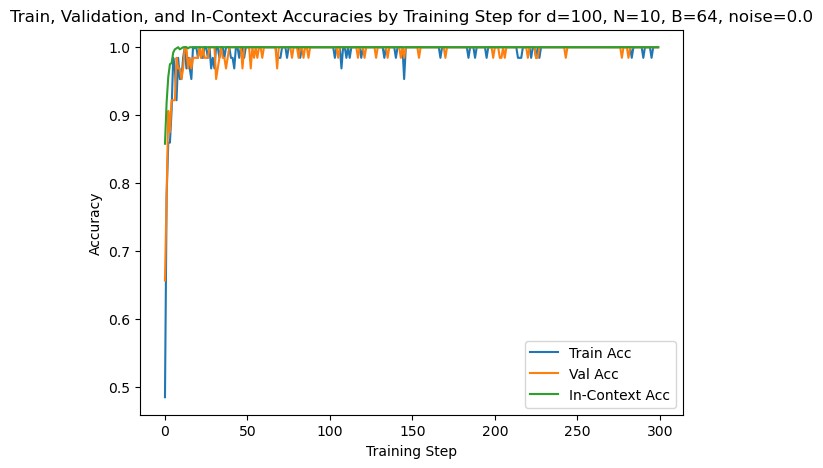

Running experiment with following hyperparams: d=300, n=20, b=64, R=5.535238985626912, flip=0.1
Step 000 | Train Loss: 0.69 | Train Acc: 0.64 | Val Loss: 0.69 | Val Acc: 0.62 | In-Context Acc: 0.68
Step 010 | Train Loss: 0.66 | Train Acc: 0.84 | Val Loss: 0.66 | Val Acc: 0.70 | In-Context Acc: 0.90
Step 020 | Train Loss: 0.63 | Train Acc: 0.88 | Val Loss: 0.64 | Val Acc: 0.81 | In-Context Acc: 0.93
Step 030 | Train Loss: 0.60 | Train Acc: 0.91 | Val Loss: 0.62 | Val Acc: 0.83 | In-Context Acc: 0.92
Step 040 | Train Loss: 0.58 | Train Acc: 0.88 | Val Loss: 0.60 | Val Acc: 0.89 | In-Context Acc: 0.93
Step 050 | Train Loss: 0.60 | Train Acc: 0.78 | Val Loss: 0.56 | Val Acc: 0.92 | In-Context Acc: 0.93
Step 060 | Train Loss: 0.63 | Train Acc: 0.78 | Val Loss: 0.54 | Val Acc: 0.92 | In-Context Acc: 0.93
Step 070 | Train Loss: 0.55 | Train Acc: 0.86 | Val Loss: 0.51 | Val Acc: 0.97 | In-Context Acc: 0.93
Step 080 | Train Loss: 0.50 | Train Acc: 0.92 | Val Loss: 0.53 | Val Acc: 0.88 | In-Cont

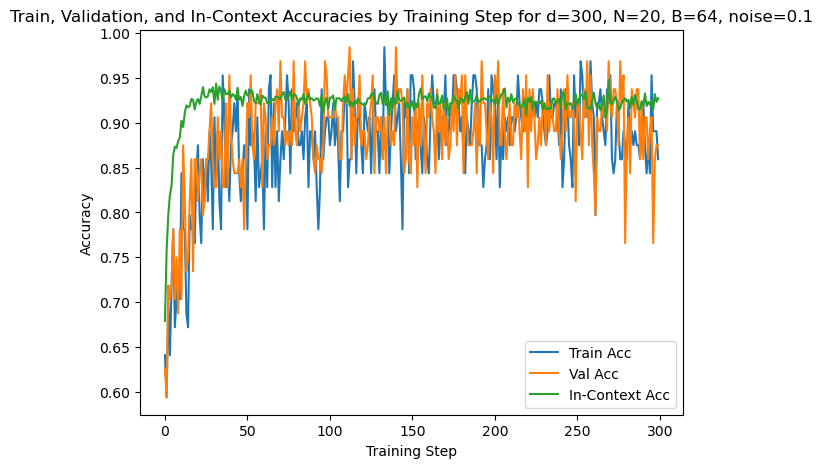

Running experiment with following hyperparams: d=500, n=40, b=64, R=6.4519501214821595, flip=0.2
Step 000 | Train Loss: 0.69 | Train Acc: 0.62 | Val Loss: 0.69 | Val Acc: 0.45 | In-Context Acc: 0.58
Step 010 | Train Loss: 0.68 | Train Acc: 0.55 | Val Loss: 0.68 | Val Acc: 0.61 | In-Context Acc: 0.74
Step 020 | Train Loss: 0.68 | Train Acc: 0.69 | Val Loss: 0.67 | Val Acc: 0.75 | In-Context Acc: 0.79
Step 030 | Train Loss: 0.68 | Train Acc: 0.61 | Val Loss: 0.66 | Val Acc: 0.67 | In-Context Acc: 0.82
Step 040 | Train Loss: 0.66 | Train Acc: 0.77 | Val Loss: 0.65 | Val Acc: 0.66 | In-Context Acc: 0.83
Step 050 | Train Loss: 0.63 | Train Acc: 0.83 | Val Loss: 0.65 | Val Acc: 0.70 | In-Context Acc: 0.84
Step 060 | Train Loss: 0.65 | Train Acc: 0.80 | Val Loss: 0.66 | Val Acc: 0.69 | In-Context Acc: 0.84
Step 070 | Train Loss: 0.63 | Train Acc: 0.75 | Val Loss: 0.64 | Val Acc: 0.73 | In-Context Acc: 0.85
Step 080 | Train Loss: 0.65 | Train Acc: 0.72 | Val Loss: 0.63 | Val Acc: 0.73 | In-Con

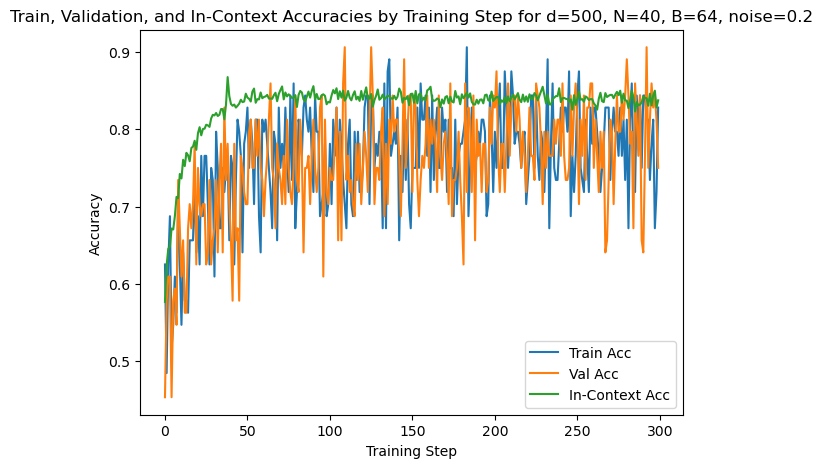

Running experiment with following hyperparams: d=1000, n=80, b=64, R=7.943282347242814, flip=0.3
Step 000 | Train Loss: 0.69 | Train Acc: 0.41 | Val Loss: 0.69 | Val Acc: 0.47 | In-Context Acc: 0.54
Step 010 | Train Loss: 0.69 | Train Acc: 0.59 | Val Loss: 0.69 | Val Acc: 0.52 | In-Context Acc: 0.59
Step 020 | Train Loss: 0.69 | Train Acc: 0.52 | Val Loss: 0.69 | Val Acc: 0.55 | In-Context Acc: 0.64
Step 030 | Train Loss: 0.69 | Train Acc: 0.55 | Val Loss: 0.69 | Val Acc: 0.59 | In-Context Acc: 0.65
Step 040 | Train Loss: 0.68 | Train Acc: 0.62 | Val Loss: 0.68 | Val Acc: 0.59 | In-Context Acc: 0.68
Step 050 | Train Loss: 0.68 | Train Acc: 0.56 | Val Loss: 0.68 | Val Acc: 0.61 | In-Context Acc: 0.68
Step 060 | Train Loss: 0.67 | Train Acc: 0.64 | Val Loss: 0.68 | Val Acc: 0.53 | In-Context Acc: 0.70
Step 070 | Train Loss: 0.68 | Train Acc: 0.66 | Val Loss: 0.67 | Val Acc: 0.59 | In-Context Acc: 0.70
Step 080 | Train Loss: 0.67 | Train Acc: 0.62 | Val Loss: 0.67 | Val Acc: 0.62 | In-Con

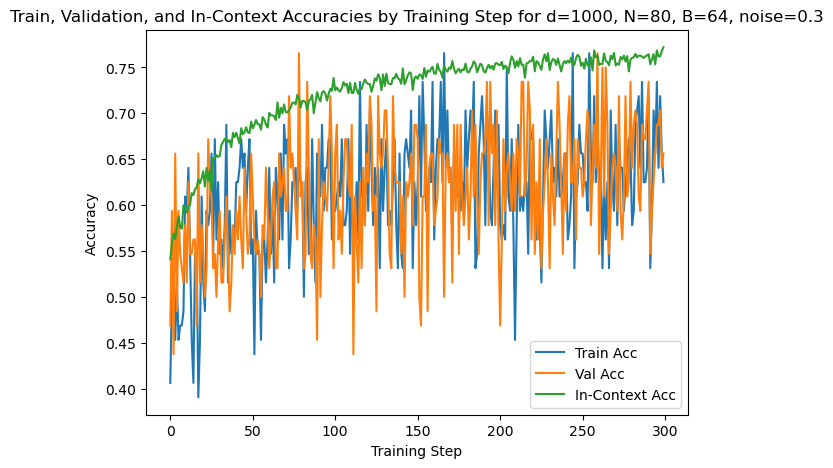

In [14]:
#run all experiments

for i in range(len(d_vals)):
    d = d_vals[i]
    N = n_vals[i]
    B = b_vals[i]
    R = r_vals[i]
    flip_train_val = flips_train[i]
    flip_val_val = flips_val[i]

    run_experiment(
        d=d,
        N=N,
        B=B,
        R_train=R,
        R_val=R,
        flip_train=flip_train_val,
        flip_val=flip_val_val,
        steps=steps,
        device=device,
    )


Running experiment with following hyperparams: d=1000, n=10, b=64, R=1.9952623149688797, flip=0.2
Step 000 | Train Loss: 0.69 | Train Acc: 0.44 | Val Loss: 0.69 | Val Acc: 0.56 | In-Context Acc: 0.48
Step 010 | Train Loss: 0.69 | Train Acc: 0.56 | Val Loss: 0.71 | Val Acc: 0.41 | In-Context Acc: 0.50
Step 020 | Train Loss: 0.73 | Train Acc: 0.44 | Val Loss: 0.69 | Val Acc: 0.61 | In-Context Acc: 0.53
Step 010 | Train Loss: 0.69 | Train Acc: 0.56 | Val Loss: 0.71 | Val Acc: 0.41 | In-Context Acc: 0.50
Step 020 | Train Loss: 0.73 | Train Acc: 0.44 | Val Loss: 0.69 | Val Acc: 0.61 | In-Context Acc: 0.53
Step 030 | Train Loss: 0.73 | Train Acc: 0.50 | Val Loss: 0.72 | Val Acc: 0.52 | In-Context Acc: 0.52
Step 040 | Train Loss: 0.71 | Train Acc: 0.48 | Val Loss: 0.72 | Val Acc: 0.52 | In-Context Acc: 0.57
Step 030 | Train Loss: 0.73 | Train Acc: 0.50 | Val Loss: 0.72 | Val Acc: 0.52 | In-Context Acc: 0.52
Step 040 | Train Loss: 0.71 | Train Acc: 0.48 | Val Loss: 0.72 | Val Acc: 0.52 | In-Co

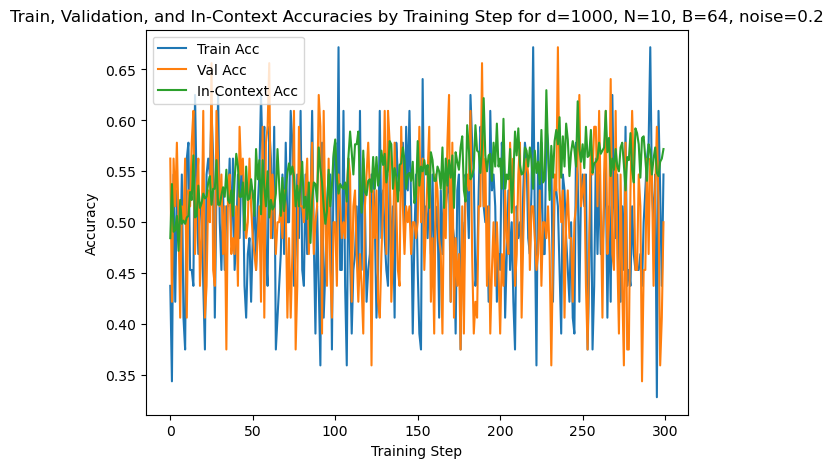

Running experiment with following hyperparams: d=1000, n=20, b=64, R=3.9810717055349727, flip=0.2
Step 000 | Train Loss: 0.69 | Train Acc: 0.52 | Val Loss: 0.69 | Val Acc: 0.44 | In-Context Acc: 0.52
Step 010 | Train Loss: 0.69 | Train Acc: 0.59 | Val Loss: 0.69 | Val Acc: 0.56 | In-Context Acc: 0.56
Step 010 | Train Loss: 0.69 | Train Acc: 0.59 | Val Loss: 0.69 | Val Acc: 0.56 | In-Context Acc: 0.56
Step 020 | Train Loss: 0.69 | Train Acc: 0.47 | Val Loss: 0.67 | Val Acc: 0.50 | In-Context Acc: 0.54
Step 020 | Train Loss: 0.69 | Train Acc: 0.47 | Val Loss: 0.67 | Val Acc: 0.50 | In-Context Acc: 0.54
Step 030 | Train Loss: 0.69 | Train Acc: 0.50 | Val Loss: 0.68 | Val Acc: 0.52 | In-Context Acc: 0.62
Step 030 | Train Loss: 0.69 | Train Acc: 0.50 | Val Loss: 0.68 | Val Acc: 0.52 | In-Context Acc: 0.62
Step 040 | Train Loss: 0.68 | Train Acc: 0.55 | Val Loss: 0.69 | Val Acc: 0.55 | In-Context Acc: 0.60
Step 040 | Train Loss: 0.68 | Train Acc: 0.55 | Val Loss: 0.69 | Val Acc: 0.55 | In-Co

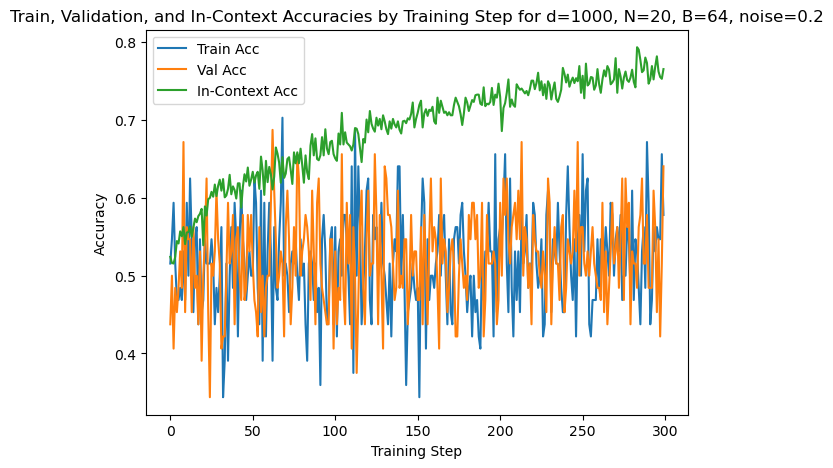

Running experiment with following hyperparams: d=1000, n=40, b=64, R=15.848931924611136, flip=0.2
Step 000 | Train Loss: 0.69 | Train Acc: 0.50 | Val Loss: 0.65 | Val Acc: 0.77 | In-Context Acc: 0.71
Step 010 | Train Loss: 0.53 | Train Acc: 0.88 | Val Loss: 0.61 | Val Acc: 0.72 | In-Context Acc: 0.81
Step 010 | Train Loss: 0.53 | Train Acc: 0.88 | Val Loss: 0.61 | Val Acc: 0.72 | In-Context Acc: 0.81
Step 020 | Train Loss: 0.52 | Train Acc: 0.83 | Val Loss: 0.56 | Val Acc: 0.78 | In-Context Acc: 0.81
Step 020 | Train Loss: 0.52 | Train Acc: 0.83 | Val Loss: 0.56 | Val Acc: 0.78 | In-Context Acc: 0.81
Step 030 | Train Loss: 0.52 | Train Acc: 0.78 | Val Loss: 0.54 | Val Acc: 0.78 | In-Context Acc: 0.80
Step 030 | Train Loss: 0.52 | Train Acc: 0.78 | Val Loss: 0.54 | Val Acc: 0.78 | In-Context Acc: 0.80
Step 040 | Train Loss: 0.63 | Train Acc: 0.75 | Val Loss: 0.52 | Val Acc: 0.81 | In-Context Acc: 0.80
Step 040 | Train Loss: 0.63 | Train Acc: 0.75 | Val Loss: 0.52 | Val Acc: 0.81 | In-Co

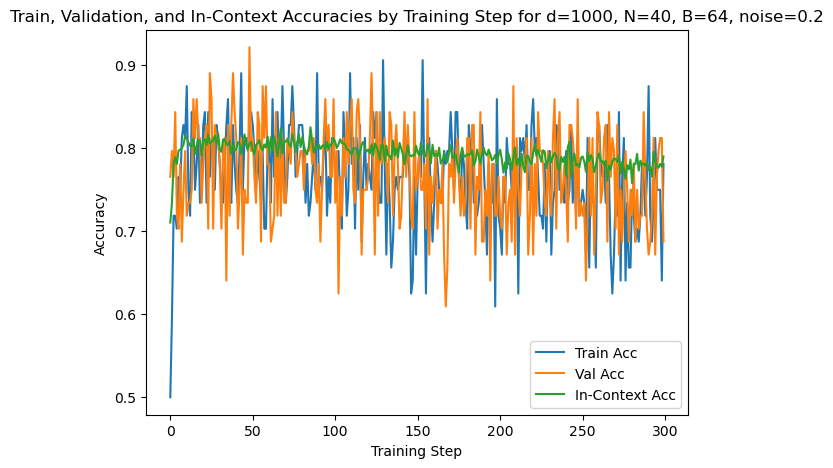

Running experiment with following hyperparams: d=1000, n=80, b=64, R=31.622776601683793, flip=0.2
Step 000 | Train Loss: 0.69 | Train Acc: 0.45 | Val Loss: 0.54 | Val Acc: 0.80 | In-Context Acc: 0.79
Step 010 | Train Loss: 0.81 | Train Acc: 0.72 | Val Loss: 0.64 | Val Acc: 0.77 | In-Context Acc: 0.71
Step 010 | Train Loss: 0.81 | Train Acc: 0.72 | Val Loss: 0.64 | Val Acc: 0.77 | In-Context Acc: 0.71
Step 020 | Train Loss: 0.84 | Train Acc: 0.72 | Val Loss: 0.78 | Val Acc: 0.67 | In-Context Acc: 0.67
Step 020 | Train Loss: 0.84 | Train Acc: 0.72 | Val Loss: 0.78 | Val Acc: 0.67 | In-Context Acc: 0.67
Step 030 | Train Loss: 1.09 | Train Acc: 0.62 | Val Loss: 0.81 | Val Acc: 0.75 | In-Context Acc: 0.69
Step 030 | Train Loss: 1.09 | Train Acc: 0.62 | Val Loss: 0.81 | Val Acc: 0.75 | In-Context Acc: 0.69
Step 040 | Train Loss: 1.05 | Train Acc: 0.67 | Val Loss: 1.37 | Val Acc: 0.62 | In-Context Acc: 0.69
Step 040 | Train Loss: 1.05 | Train Acc: 0.67 | Val Loss: 1.37 | Val Acc: 0.62 | In-Co

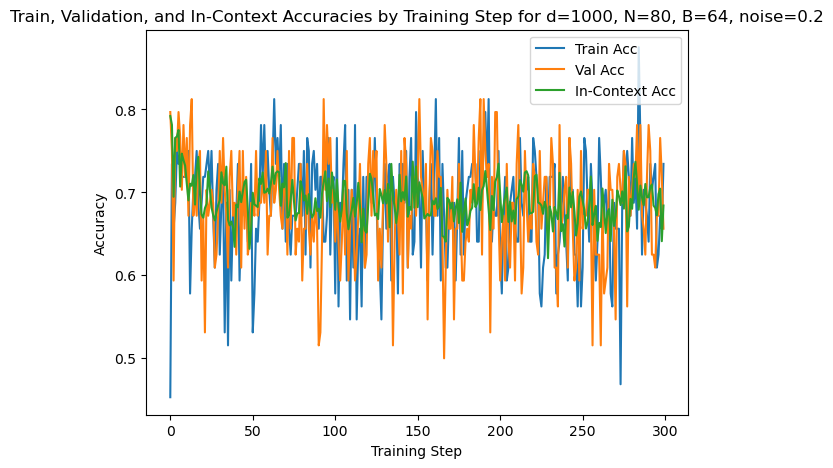

In [23]:
#training loop will run with all values in index 0, then 1, etc.
d_vals = [1000, 1000, 1000, 1000]
n_vals = [10, 20, 40, 80]
b_vals = [64, 64, 64, 64]
snr_exp = [0.1, 0.2, 0.4, 0.5]              
r_vals = [x ** y for x, y in zip(d_vals, snr_exp)]
flips_train = [0.2, 0.2,0.2,0.2]
flips_val = flips_train

steps = 300
device = "cuda"
for i in range(len(d_vals)):
    d = d_vals[i]
    N = n_vals[i]
    B = b_vals[i]
    R = r_vals[i]
    flip_train_val = flips_train[i]
    flip_val_val = flips_val[i]

    run_experiment(
        d=d,
        N=N,
        B=B,
        R_train=R,
        R_val=R,
        flip_train=flip_train_val,
        flip_val=flip_val_val,
        steps=steps,
        device=device,
    )

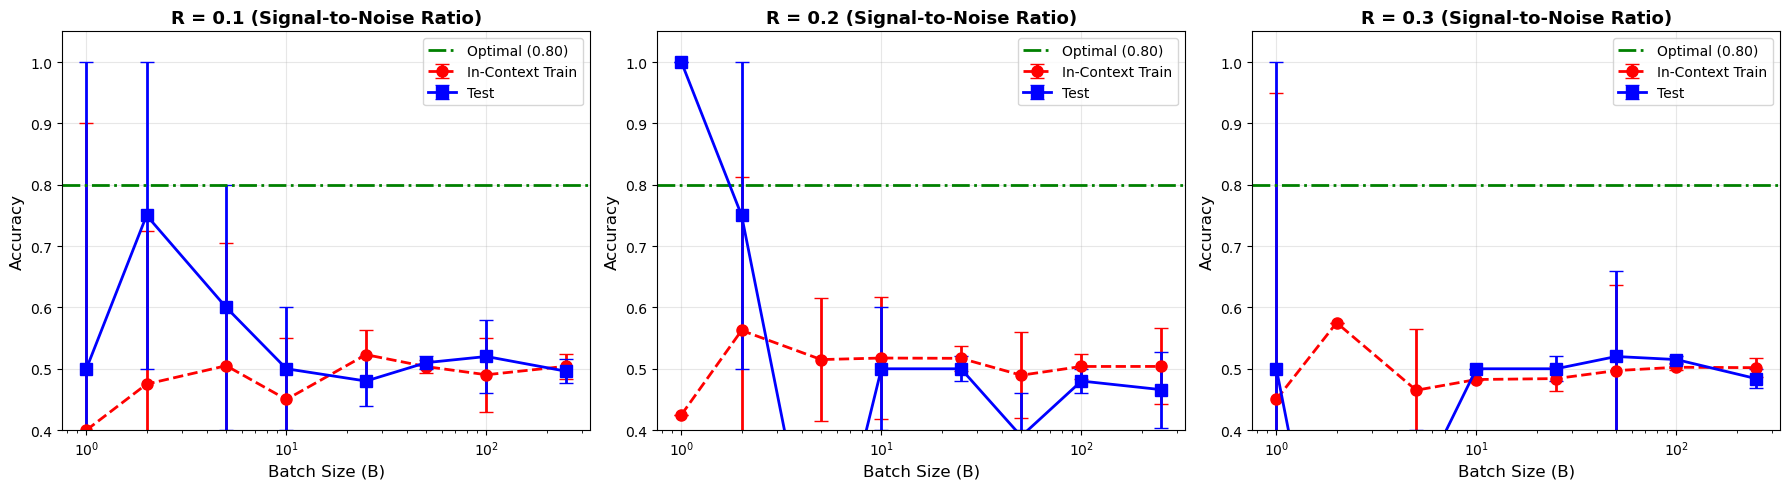

Figure saved as 'batch_size_vs_R_experiments.png'


In [18]:
# Visualization: Batch Size Scaling Across Different R Values

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors_ic = ['red', 'darkred', 'maroon']
colors_test = ['blue', 'darkblue', 'navy']

for idx, R in enumerate(R_values):
    ax = axes[idx]
    results = all_results[R]
    batch_sizes = results['batch_sizes']
    test_acc = results['test_acc']
    test_acc_std = results['test_acc_std']
    ic_acc = results['ic_acc']
    ic_acc_std = results['ic_acc_std']
    
    # Plot with error bars
    ax.errorbar(batch_sizes, ic_acc, yerr=test_acc_std, label='In-Context Train', 
                color='red', marker='o', linestyle='--', linewidth=2, markersize=8, capsize=5)
    ax.errorbar(batch_sizes, test_acc, yerr=test_acc_std, label='Test', 
                color='blue', marker='s', linestyle='-', linewidth=2, markersize=8, capsize=5)
    
    # Add optimal line
    optimal = 1.0 - 0.2  # 0.2 is flip probability
    ax.axhline(y=optimal, color='green', linestyle='-.', linewidth=2, label=f'Optimal ({optimal:.2f})')
    
    ax.set_xlabel('Batch Size (B)', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'R = {R} (Signal-to-Noise Ratio)', fontsize=13, fontweight='bold')
    ax.set_xscale('log')
    ax.set_ylim(0.4, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.tight_layout()
# plt.savefig('batch_size_vs_R_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'batch_size_vs_R_experiments.png'")



R-VALUE SCALING EXPERIMENT: Signal-to-Noise Ratio Analysis

Testing R = 0.1...
----------------------------------------------------------------------
Step 000 | Train Loss: 0.69 | Train Acc: 0.45 | Val Loss: 0.69 | Val Acc: 0.62 | In-Context Acc: 0.50
Step 000 | Train Loss: 0.69 | Train Acc: 0.45 | Val Loss: 0.69 | Val Acc: 0.62 | In-Context Acc: 0.50
Step 010 | Train Loss: 0.70 | Train Acc: 0.47 | Val Loss: 0.71 | Val Acc: 0.30 | In-Context Acc: 0.51
Step 010 | Train Loss: 0.70 | Train Acc: 0.47 | Val Loss: 0.71 | Val Acc: 0.30 | In-Context Acc: 0.51
Step 020 | Train Loss: 0.69 | Train Acc: 0.48 | Val Loss: 0.70 | Val Acc: 0.44 | In-Context Acc: 0.52
Step 020 | Train Loss: 0.69 | Train Acc: 0.48 | Val Loss: 0.70 | Val Acc: 0.44 | In-Context Acc: 0.52
Step 030 | Train Loss: 0.69 | Train Acc: 0.53 | Val Loss: 0.70 | Val Acc: 0.53 | In-Context Acc: 0.51
Step 030 | Train Loss: 0.69 | Train Acc: 0.53 | Val Loss: 0.70 | Val Acc: 0.53 | In-Context Acc: 0.51
Step 040 | Train Loss: 0.69 | Tra

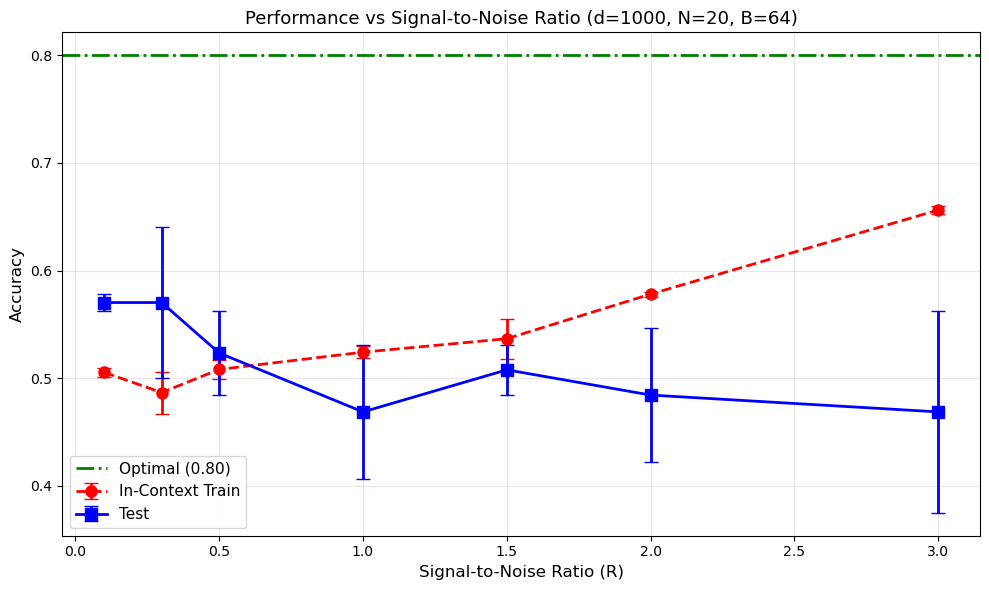


Figure saved as 'r_scaling_analysis.png'


In [19]:

# R-Value Scaling Experiment: Test Different Signal-to-Noise Ratios
# Fixed dimension, varying R values

print("\n" + "="*70)
print("R-VALUE SCALING EXPERIMENT: Signal-to-Noise Ratio Analysis")
print("="*70)

# Fixed parameters
d_fixed = 1000
N_fixed = 20
B_fixed = 64
r_test_vals = [0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 3.0]
flip_train_fixed = 0.2
flip_val_fixed = 0.2
steps_r_exp = 300
device = "cuda"

r_results = {}

for R in r_test_vals:
    print(f"\nTesting R = {R}...")
    print("-" * 70)
    
    # Train multiple runs for each R
    test_accs = []
    ic_accs = []
    
    for run in range(2):  # 2 runs per R value
        model = LinearClassifier(d=d_fixed)
        
        metrics = train_model(
            model,
            d=d_fixed,
            N=N_fixed,
            B=B_fixed,
            R_train=R,
            R_val=R,
            flip_train=flip_train_fixed,
            flip_val=flip_val_fixed,
            steps=steps_r_exp,
            device=device,
            return_metrics=False
        )
        
        # Evaluate final performance
        val_loss, val_acc, ctx_acc = evaluate(
            model, d_fixed, N_fixed, B_fixed, R, flip_val=flip_val_fixed, device=device
        )
        
        test_accs.append(val_acc)
        ic_accs.append(ctx_acc)
        print(f"  Run {run+1}: Test Acc = {val_acc:.3f}, IC Acc = {ctx_acc:.3f}")
    
    r_results[R] = {
        'test_acc_mean': np.mean(test_accs),
        'test_acc_std': np.std(test_accs),
        'ic_acc_mean': np.mean(ic_accs),
        'ic_acc_std': np.std(ic_accs)
    }

# Print summary table
print("\n" + "="*70)
print("R-VALUE EXPERIMENT SUMMARY")
print("="*70)
print(f"Fixed parameters: d={d_fixed}, N={N_fixed}, B={B_fixed}, flip={flip_train_fixed}\n")

for R in r_test_vals:
    res = r_results[R]
    print(f"R = {R:4.1f}:  Test Acc = {res['test_acc_mean']:.3f} ± {res['test_acc_std']:.3f}  |  "
          f"IC Acc = {res['ic_acc_mean']:.3f} ± {res['ic_acc_std']:.3f}")

# Plot R-scaling results
plt.figure(figsize=(10, 6))
r_vals_list = list(r_results.keys())
test_means = [r_results[r]['test_acc_mean'] for r in r_vals_list]
test_stds = [r_results[r]['test_acc_std'] for r in r_vals_list]
ic_means = [r_results[r]['ic_acc_mean'] for r in r_vals_list]
ic_stds = [r_results[r]['ic_acc_std'] for r in r_vals_list]

plt.errorbar(r_vals_list, ic_means, yerr=ic_stds, label='In-Context Train', 
             color='red', marker='o', linestyle='--', linewidth=2, markersize=8, capsize=5)
plt.errorbar(r_vals_list, test_means, yerr=test_stds, label='Test', 
             color='blue', marker='s', linestyle='-', linewidth=2, markersize=8, capsize=5)

optimal = 1.0 - flip_train_fixed
plt.axhline(y=optimal, color='green', linestyle='-.', linewidth=2, label=f'Optimal ({optimal:.2f})')

plt.xlabel('Signal-to-Noise Ratio (R)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title(f'Performance vs Signal-to-Noise Ratio (d={d_fixed}, N={N_fixed}, B={B_fixed})', fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('r_scaling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'r_scaling_analysis.png'")
